In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
#Training set seulement
df = pd.read_csv('train.csv')
df.drop(['PassengerId','Ticket'], axis=1, inplace=True)
df.Age.fillna(df.Age.median(),inplace=True)

In [14]:
split = df.Name.str.split(' ',expand=True)

In [15]:
Title = pd.DataFrame(index=range(len(df)),columns=['Title'])

for i in range(len(df)):
    if ',' in split.iloc[i,1]:
        Title.iloc[i,0]= split.iloc[i,2]
    else:
        Title.iloc[i,0]= split.iloc[i,1]

df_exp = df.join(Title)
df_exp.drop(['Name'],axis=1, inplace=True)

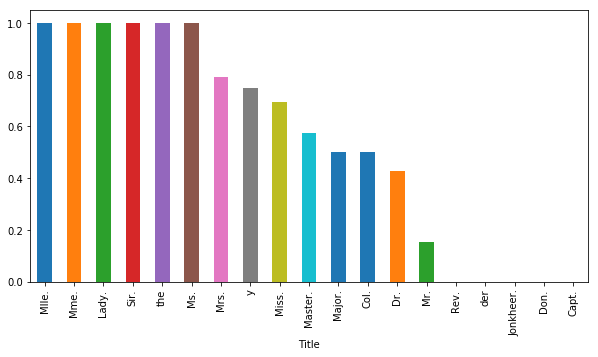

In [16]:
df_exp.groupby('Title')['Survived'].mean().sort_values(ascending=False).plot(kind='bar', figsize=(10,5))

In [17]:
df_exp['Sex'] = df_exp['Sex'].map({'male':0,'female':1}).astype(int)
EmDum = pd.get_dummies(df_exp.Embarked, prefix='Embarked')
EmDum.drop('Embarked_C', axis=1, inplace=True)
df_exp = df_exp.join(EmDum)
df_exp.drop('Embarked',axis=1, inplace=True)

In [18]:
TiDum = pd.get_dummies(df_exp.Title, prefix='Title')
TiDum.drop(['Title_y','Title_Jonkheer.','Title_der','Title_the'],axis=1,inplace=True)
df_exp = df_exp.join(TiDum)
df_exp = df_exp.drop(['Title'],axis=1)

In [19]:
CabLet = df_exp.Cabin.str[0]
CabLet.fillna('O', inplace=True)
CabLet = pd.get_dummies(CabLet, prefix='Deck')
CabLet.drop('Deck_O', axis=1, inplace=True)
df_exp = df_exp.join(CabLet)
df_exp.drop('Cabin',axis=1, inplace=True)

df_exp.to_csv('Titanic_training_set.csv')

In [20]:
#Maintenant le test set... same thing
dfTest = pd.read_csv('test.csv')
dfTest.drop(['PassengerId','Ticket'], axis=1, inplace=True)
dfTest.Age.fillna(df_exp.Age.median(),inplace=True)

splitTest = dfTest.Name.str.split(' ',expand=True)

TitleTest = pd.DataFrame(index=range(len(dfTest)),columns=['Title'])

for i in range(len(dfTest)):
    if ',' in splitTest.iloc[i,1]:
        TitleTest.iloc[i,0]= splitTest.iloc[i,2]
    else:
        TitleTest.iloc[i,0]= splitTest.iloc[i,1]

df_expTest = dfTest.join(Title)
df_expTest.drop(['Name'],axis=1, inplace=True)

df_expTest['Sex'] = df_expTest['Sex'].map({'male':0,'female':1}).astype(int)
EmDumTest = pd.get_dummies(df_expTest.Embarked, prefix='Embarked')
EmDumTest.drop('Embarked_C', axis=1, inplace=True)
df_expTest = df_expTest.join(EmDumTest)
df_expTest.drop('Embarked',axis=1, inplace=True)

TiDumTest = pd.get_dummies(df_expTest.Title, prefix='Title')
TiDumTest.drop(['Title_y','Title_der'],axis=1,inplace=True)
df_expTest = df_expTest.join(TiDumTest)
df_expTest = df_expTest.drop(['Title'],axis=1)

CabLetTest = df_expTest.Cabin.str[0]
CabLetTest.fillna('O', inplace=True)
CabLetTest = pd.get_dummies(CabLetTest, prefix='Deck')
CabLetTest.drop('Deck_O', axis=1, inplace=True)
df_expTest = df_expTest.join(CabLetTest)
df_expTest.drop('Cabin',axis=1, inplace=True)

df_expTest.Fare.fillna(df_expTest.Fare.median(),inplace=True)

df_expTest.to_csv('Titanic_test_set.csv')

In [ ]:
X_train = df_exp.drop(['Survived','Title_Capt.','Title_Col.','Title_Lady.','Title_Major.','Title_Mlle.','Title_Ms.','Title_Sir.','Deck_T'],axis=1)
y_train = df.Survived
X_test = df_expTest

In [ ]:
from sklearn.linear_model import LogisticRegression
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)
LogRegRes = LogReg.predict(X_test)

In [ ]:
submissionEx = pd.read_csv('../input/gender_submission.csv')
Id = submissionEx.PassengerId
LogRegRes_Sub = pd.Series(LogRegRes, name='Survived')
victory = pd.concat([Id,LogRegRes_Sub],axis=1)

In [ ]:
victory.to_csv('mysubmission.csv',index=False)

In [ ]:
print('Score:',LogReg.score(X_train, y_train))
from sklearn.metrics import classification_report
print(classification_report(y_train, LogReg.predict(X_train)))

In [ ]:
from sklearn.model_selection import train_test_split
X_trainCV, x_testCV, Y_trainCV, y_testCV = train_test_split(X_train, y_train, train_size=0.7)
LogRegCV = LogisticRegression()
LogRegCV.fit(X_trainCV, Y_trainCV)
LogRegResCV = LogRegCV.predict(x_testCV)

print('Score:',LogRegCV.score(X_trainCV, Y_trainCV))
print(classification_report(y_testCV, LogRegResCV))

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_trainCV_std = sc.fit_transform(X_trainCV)
x_testCV_std = sc.fit_transform(x_testCV)

LogRegCV2 = LogisticRegression()
LogRegCV2.fit(X_trainCV_std, Y_trainCV)
LogRegResCV2 = LogRegCV2.predict(x_testCV_std)

print('Score:',LogRegCV2.score(X_trainCV_std, Y_trainCV))
print(classification_report(y_testCV, LogRegResCV2))

In [ ]:
from sklearn.metrics import accuracy_score

C_range = [0.001, 0.01, 0.1, 1, 10, 100]

acc_table = pd.DataFrame(columns=['C','Acc'])
acc_table['C'] = C_range

j=0
for i in C_range:
    lr = LogisticRegression(C = i, random_state = 0)
    lr.fit(X_trainCV_std, Y_trainCV)
    y_pred = lr.predict(x_testCV_std)
    acc_table.iloc[j,1]=accuracy_score(y_pred, y_testCV)
    j+=1
    
acc_table

acc_table.plot(kind='bar', x='C', y='Acc')
